In [ ]:
global file_path 
file_path = "/forms-results/finals/Questionario per studenti.csv"  # Adjust path if needed

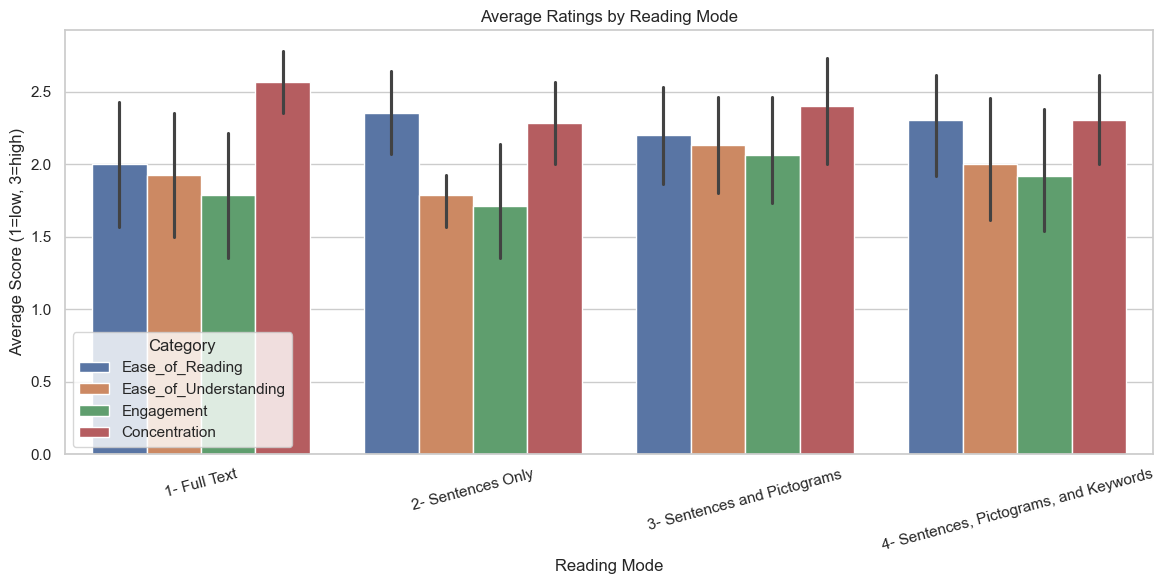

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(file_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is the original DataFrame loaded from the CSV

# Rename relevant columns
df = df.rename(columns={
    df.columns[3]: "Ease_of_Reading",
    df.columns[4]: "Ease_of_Understanding",
    df.columns[5]: "Engagement",
    df.columns[6]: "Concentration",
    df.columns[7]: "Suggestions"
})

# Translate modality names
df["Reading_Mode"] = df["Modalità di lettura"].replace({
    "1- Testo completo": "1- Full Text",
    "2- Solo Frasi": "2- Sentences Only",
    "3- Frasi e Pittogrammi": "3- Sentences and Pictograms",
    "4- Frasi, Pittogrammi e Parole Chiave": "4- Sentences, Pictograms, and Keywords"
})

# Melt the DataFrame for plotting
melted_df = df.melt(id_vars=["Reading_Mode"], 
                    value_vars=["Ease_of_Reading", "Ease_of_Understanding", "Engagement", "Concentration"],
                    var_name="Category", value_name="Score")

# Set up plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x="Reading_Mode", y="Score", hue="Category")
plt.title("Average Ratings by Reading Mode")
plt.ylabel("Average Score (1=low, 3=high)")
plt.xlabel("Reading Mode")
plt.xticks(rotation=15)
plt.legend(title="Category")
plt.tight_layout()
plt.show()



In [20]:
# STEP 1: Prepare and clean suggestions
valid_suggestions = df["Suggestions"].dropna().astype(str)
valid_suggestions = valid_suggestions[~valid_suggestions.str.lower().isin([
    "no", "niente", "nulla", "n", "nessuna", "nessuno", "non lo so"
])]

# STEP 2: TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(valid_suggestions)

# STEP 3: KMeans clustering
n_clusters = min(5, len(valid_suggestions))  # up to 5 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# STEP 4: PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# STEP 5: Create a DataFrame for plotting
pca_df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Suggestion": valid_suggestions.values,
    "Cluster": labels
})

# STEP 6: Assign human-readable themes to each cluster (manual mapping)
theme_mapping = {
    0: "Add Drawings",
    1: "Simplify Language",
    2: "Longer or Simpler Sentences",
    3: "Include More Images",
    4: "Easier Words / Clarity"
}

pca_df["Theme"] = pca_df["Cluster"].map(theme_mapping)

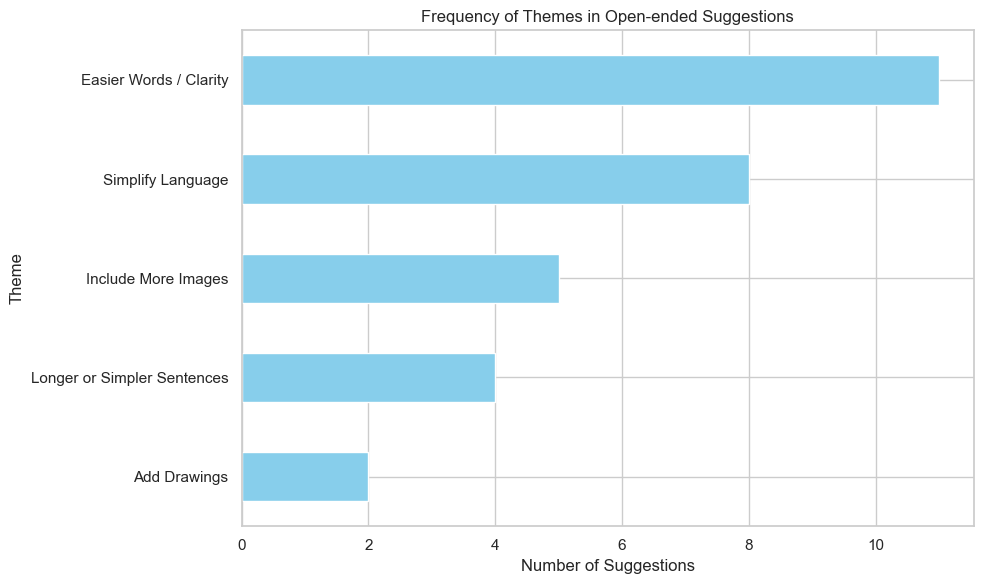

In [ ]:
# Bar chart of theme frequencies
theme_counts = pca_df["Theme"].value_counts().sort_values()
plt.figure(figsize=(10, 6))
theme_counts.plot(kind='barh', color="skyblue")
plt.title("Frequency of Themes in Open-ended Suggestions")
plt.xlabel("Number of Suggestions")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

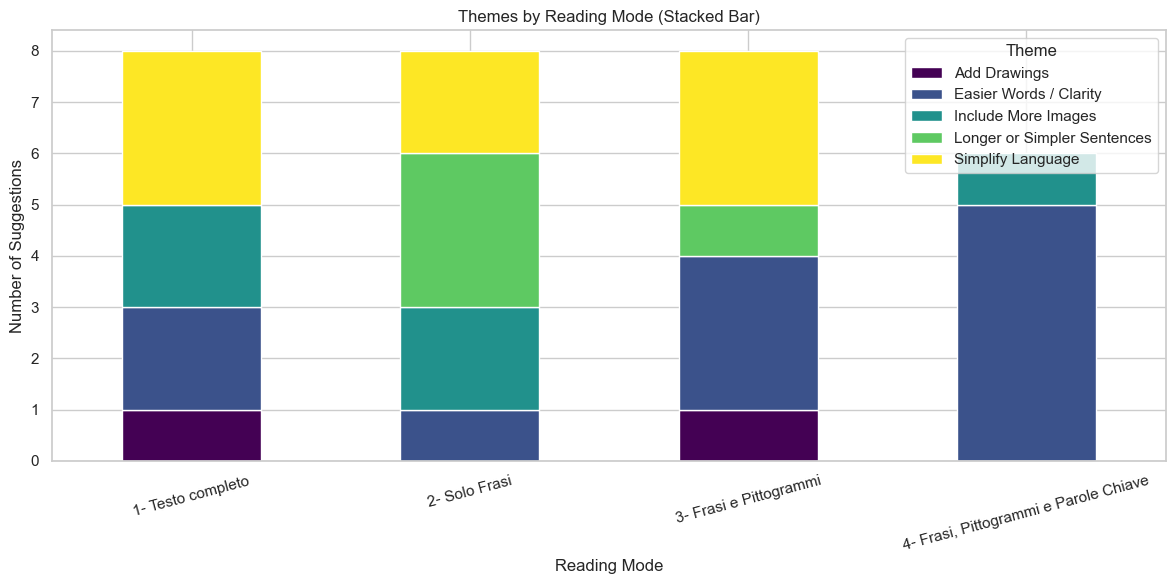

In [22]:
# Merge reading mode info from original DataFrame
theme_by_mode = df[["Modalità di lettura"]].join(pca_df[["Theme"]], how='right')

# Cross-tabulate themes by reading mode
theme_mode_ct = pd.crosstab(theme_by_mode["Modalità di lettura"], theme_by_mode["Theme"])

# Plot
theme_mode_ct.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Themes by Reading Mode (Stacked Bar)")
plt.xlabel("Reading Mode")
plt.ylabel("Number of Suggestions")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

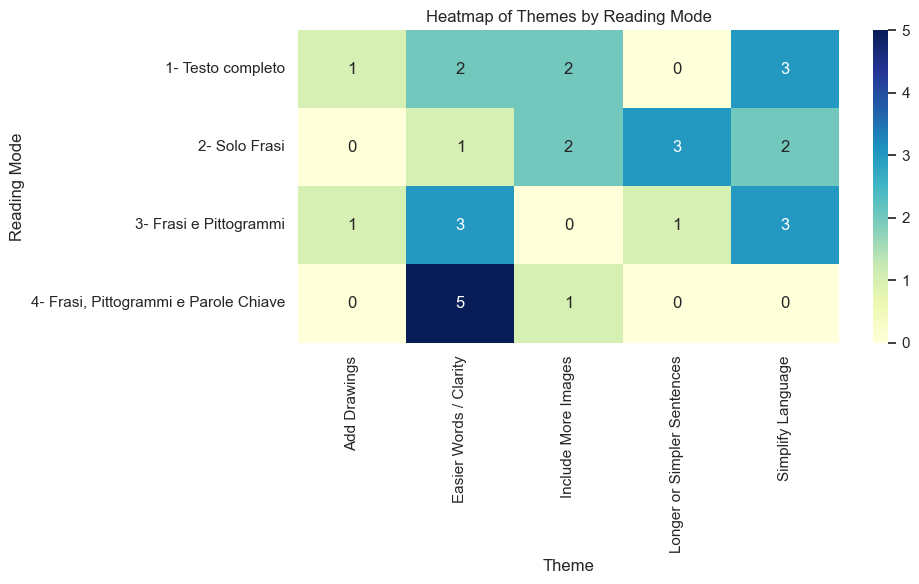

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(theme_mode_ct, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Heatmap of Themes by Reading Mode")
plt.xlabel("Theme")
plt.ylabel("Reading Mode")
plt.tight_layout()
plt.show()